In [24]:
!pip install tf_gnns
!pip install --quiet 'networkx<3'

In [25]:
#@title ##### `tf_gnns` license
# Copyright 2021, Mylonas Charilaos. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# ##### `DeepMind GraphNets` license
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

###############################################################################
# Changes to the original file:
# ------------------------------
# This notebook is a modified version of the `deepmind/graph_nets` example code
# which demonstrates the use of graph nets to list sorting. The parts of code
# from the original file are the sampling of GraphTuples which contain the input
# and output graphs. The parts that are different are the parts needed to use
# the tf_gnns library instead of the graph nets. More speciffically, a function
# that casts graphtuples to tensor_dicts is created, and an EncodeProcessDecode
# network almost identical to the one used in the paper is created.
# Visualization is also different from the original file, yet very similar.


# List sorting with GNNs
A large part of the code for this example is taken from the [deepmind/graph_nets](https://github.com/deepmind/graph_nets/blob/master/graph_nets/) library (the Apache licence of `graph_nets` is also attached). In this notebook, the exact code that generates the data used in the DeepMind `graph_nets` example is used, but the GN used for processing is usgin the `tf_gnns` functionality (no tf 1.x or Sonnet).

In [26]:
install_graph_nets_library = "Yes"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library and dependencies:")
  print("Output message from command:\n")
  !pip install "graph_nets>=1.1" "dm-sonnet>=2.0.0b0"
else:
  print("Skipping installation of Graph Nets library")

Installing Graph Nets library and dependencies:
Output message from command:



In [27]:
#@title Imports

## Needed for manipulating the samplers from the graph_nets library (and making
#  a 1-to-1 comparisson of the two frameworks)

from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tf_gnns.models.graphnet import GraphNetMLP, GNCellMLP, GraphIndep
import tensorflow as tf

SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [28]:
#@title Helper functions  { form-width: "30%" }

# pylint: disable=redefined-outer-name

def create_graph_dicts_tf(num_examples, num_elements_min_max):
  """Generate graphs for training.

  Args:
    num_examples: total number of graphs to generate
    num_elements_min_max: a 2-tuple with the minimum and maximum number of
      values allowable in a graph. The number of values for a graph is
      uniformly sampled withing this range. The upper bound is exclusive, and
      should be at least 2 more than the lower bound.

  Returns:
    inputs: contains the generated random numbers as node values.
    sort_indices: contains the sorting indices as nodes. Concretely
      inputs.nodes[sort_indices.nodes] will be a sorted array.
    ranks: the rank of each value in inputs normalized to the range [0, 1].
  """
  num_elements = tf.random.uniform(
      [num_examples],
      minval=num_elements_min_max[0],
      maxval=num_elements_min_max[1],
      dtype=tf.int32)
  inputs_graphs = []
  sort_indices_graphs = []
  ranks_graphs = []
  for i in range(num_examples):
    values = tf.random.uniform(shape=[num_elements[i]])
    sort_indices = tf.cast(
        tf.argsort(values, axis=-1), tf.float32)
    ranks = tf.cast(
        tf.argsort(sort_indices, axis=-1), tf.float32) / (
            tf.cast(num_elements[i], tf.float32) - 1.0)
    inputs_graphs.append({"nodes": values[:, None]})
    sort_indices_graphs.append({"nodes": sort_indices[:, None]})
    ranks_graphs.append({"nodes": ranks[:, None]})
  return inputs_graphs, sort_indices_graphs, ranks_graphs


def create_linked_list_target(batch_size, input_graphs):
  """Creates linked list targets.

  Returns a graph with the same number of nodes as `input_graph`. Each node
  contains a 2d vector with targets for a 1-class classification where only one
  node is `True`, the smallest value in the array. The vector contains two
  values: [prob_true, prob_false].
  It also contains edges connecting all nodes. These are again 2d vectors with
  softmax targets [prob_true, prob_false]. An edge is True
  if n+1 is the element immediately after n in the sorted list.

  Args:
    batch_size: batch size for the `input_graphs`.
    input_graphs: a `graphs.GraphsTuple` which contains a batch of inputs.

  Returns:
    A `graphs.GraphsTuple` with the targets, which encode the linked list.
  """
  target_graphs = []
  for i in range(batch_size):
    input_graph = utils_tf.get_graph(input_graphs, i)
    num_elements = tf.shape(input_graph.nodes)[0]
    si = tf.cast(tf.squeeze(input_graph.nodes), tf.int32)
    nodes = tf.reshape(tf.one_hot(si[:1], num_elements), (-1, 1))
    x = tf.stack((si[:-1], si[1:]))[None]
    y = tf.stack(
        (input_graph.senders, input_graph.receivers), axis=1)[:, :, None]
    edges = tf.reshape(
        tf.cast(
            tf.reduce_any(tf.reduce_all(tf.equal(x, y), axis=1), axis=1),
            tf.float32), (-1, 1))
    target_graphs.append(input_graph._replace(nodes=nodes, edges=edges))
  return utils_tf.concat(target_graphs, axis=0)


def compute_accuracy(target, output):
  """Calculate model accuracy.

  Returns the number of correctly predicted links and the number
  of completely solved list sorts (100% correct predictions).

  Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.

  Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.
  """
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  cs = []
  ss = []
  for td, od in zip(tdds, odds):
    num_elements = td["nodes"].shape[0]
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)

    xe = np.reshape(
        np.argmax(
            np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
        (-1,))
    ye = np.reshape(
        np.argmax(
            np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
        (-1,))
    c = np.concatenate((xn == yn, xe == ye), axis=0)
    s = np.all(c)
    cs.append(c)
    ss.append(s)
  correct = np.mean(np.concatenate(cs, axis=0))
  solved = np.mean(np.stack(ss))
  return correct, solved


def create_data(batch_size, num_elements_min_max):
  """Returns graphs containing the inputs and targets for classification.

  Refer to create_data_dicts_tf and create_linked_list_target for more details.

  Args:
    batch_size: batch size for the `input_graphs`.
    num_elements_min_max: a 2-`tuple` of `int`s which define the [lower, upper)
      range of the number of elements per list.

  Returns:
    inputs: a `graphs.GraphsTuple` which contains the input list as a graph.
    targets: a `graphs.GraphsTuple` which contains the target as a graph.
    sort_indices: a `graphs.GraphsTuple` which contains the sort indices of
      the list elements a graph.
    ranks: a `graphs.GraphsTuple` which contains the ranks of the list
      elements as a graph.
  """
  inputs, sort_indices, ranks = create_graph_dicts_tf(
      batch_size, num_elements_min_max)
  inputs = utils_tf.data_dicts_to_graphs_tuple(inputs)
  sort_indices = utils_tf.data_dicts_to_graphs_tuple(sort_indices)
  ranks = utils_tf.data_dicts_to_graphs_tuple(ranks)

  inputs = utils_tf.fully_connect_graph_dynamic(inputs)
  sort_indices = utils_tf.fully_connect_graph_dynamic(sort_indices)
  ranks = utils_tf.fully_connect_graph_dynamic(ranks)

  targets = create_linked_list_target(batch_size, sort_indices)
  nodes = tf.concat((targets.nodes, 1.0 - targets.nodes), axis=1)
  edges = tf.concat((targets.edges, 1.0 - targets.edges), axis=1)
  targets = targets._replace(nodes=nodes, edges=edges)

  return inputs, targets, sort_indices, ranks


def create_loss(target, outputs):
  """Returns graphs containing the inputs and targets for classification.

  Refer to create_data_dicts_tf and create_linked_list_target for more details.

  Args:
    target: a `graphs.GraphsTuple` which contains the target as a graph.
    outputs: a `list` of `graphs.GraphsTuple`s which contains the model
      outputs for each processing step as graphs.

  Returns:
    A `list` of ops which are the loss for each processing step.
  """
  # if not isinstance(outputs, collections.Sequence):
  #   outputs = [outputs]
  losss = [
      tf.compat.v1.losses.softmax_cross_entropy(target.nodes, output.nodes) +
      tf.compat.v1.losses.softmax_cross_entropy(target.edges, output.edges)
      for output in outputs
  ]
  return tf.stack(losss)



def plot_linked_list(ax, graph, sort_indices):
  """Plot a networkx graph containing weights for the linked list probability."""
  nd = len(graph.nodes())
  probs = np.zeros((nd, nd))
  for edge in graph.edges(data=True):
    probs[edge[0], edge[1]] = edge[2]["features"][0]
  ax.matshow(probs[sort_indices][:, sort_indices], cmap="viridis")
  ax.grid(False)


# pylint: enable=redefined-outer-name

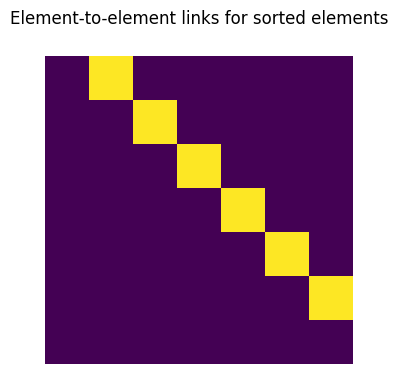

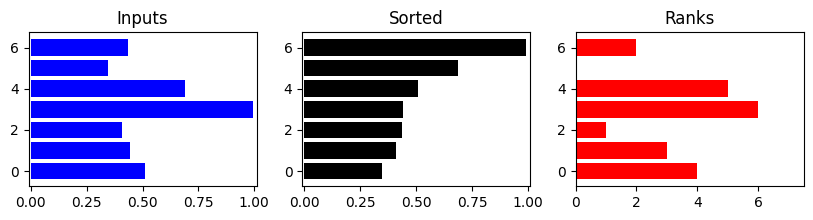

In [29]:
#@title Visualize the sort task  { form-width: "30%" }
num_elements_min_max = (5, 10)

inputs, targets, sort_indices, ranks = create_data(
    1, num_elements_min_max)

inputs_nodes = inputs.nodes.numpy()
targets = utils_tf.nest_to_numpy(targets)
sort_indices_nodes = sort_indices.nodes.numpy()
ranks_nodes = ranks.nodes.numpy()

sort_indices = np.squeeze(sort_indices_nodes).astype(int)

# Plot sort linked lists.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.
fig = plt.figure(1, figsize=(4, 4))
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_linked_list(ax,
                 utils_np.graphs_tuple_to_networkxs(targets)[0], sort_indices)
ax.set_title("Element-to-element links for sorted elements")
ax.set_axis_off()

fig = plt.figure(2, figsize=(10, 2))
fig.clf()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

i = 0
num_elements = ranks_nodes.shape[0]
inputs = np.squeeze(inputs_nodes)
ranks = np.squeeze(ranks_nodes * (num_elements - 1.0)).astype(int)
x = np.arange(inputs.shape[0])

ax1.set_title("Inputs")
ax1.barh(x, inputs, color="b")
ax1.set_xlim(-0.01, 1.01)

ax2.set_title("Sorted")
ax2.barh(x, inputs[sort_indices], color="k")
ax2.set_xlim(-0.01, 1.01)

ax3.set_title("Ranks")
ax3.barh(x, ranks, color="r")
_ = ax3.set_xlim(0, len(ranks) + 0.5)

In [30]:
from tf_gnns.lib.gt_ops import _concat_tensordicts
from tf_gnns.lib.gt_ops import _add_gt
class EncodeProcessDecode(tf.keras.Model):
    """
    The same model as in graph_nets library (16 layer wide, 2-layer ReLU MLPs
    with activation at the last layer and layer normalization as MLPs):

    Graphic from `graph_nets` library:

                        Hidden(t)   Hidden(t+1)
                         |            ^
            *---------*  |  *------*  |  *---------*
            |         |  |  |      |  |  |         |
  Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
            |         |---->|      |     |         |
            *---------*     *------*     *---------*

    In deepmind/graph_nets there is an additional linear GraphIndependent layer
    to the decoder with dense MLPs than the ones shown here.
    """
    def __init__(self, num_processing_steps = 10, num_units=16):

        super(EncodeProcessDecode,self).__init__()
        self.gn_enc = GraphIndep(num_units, gn_mlp_units = [num_units,num_units],
                                  layernorm_last_layer = True,
                                  activate_last_layer = True)

        self.gn_core   = GNCellMLP(num_units, core_size=num_units,
                                  aggregation_function = 'sum',
                                layernorm_last_layer = True,
                                activate_last_layer = True)

        # The following two layers are used to make an implementation closer
        # to what the deepmind/graph_nets library implements.
        # In tf_gnns one may alteratively use a single decoder that outputs
        # 2-dim outputs using ... "gn_mlp_units = [num_units, num_units, 2]"
        self.gn_dec = GraphIndep(num_units,gn_mlp_units = [num_units,num_units],
                                 layernorm_last_layer = True,
                                  activate_last_layer = True)

        self.gn_output_transform = GraphIndep(2, []) # nodes and edges are both with output
                                        # size 2.

        self.num_processing_steps = num_processing_steps

    def call(self, graph_in):

        g_ = self.gn_enc(graph_in)
        g_0_ = g_.copy()

        outputs = [];
        for ii in range(self.num_processing_steps):
            g_ = self.gn_core(_concat_tensordicts(g_, g_0_))
            g_to_dec = self.gn_dec(g_)
            outputs.append(self.gn_output_transform(g_to_dec))

        return outputs


In [31]:
#@title Set up model training and evaluation  { form-width: "30%" }


# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps = 10
# Data / training parameters.
num_training_iterations = 6000
batch_size_tr = 32
batch_size_ge = 100
# Number of elements in each list is sampled uniformly from this range.
num_elements_min_max_tr = (8, 17)
num_elements_min_max_ge = (16, 33)

# Data.
if 'get_data' not in  locals().keys():
    @tf.function
    def get_data():
        inputs_tr, targets_tr, sort_indices_tr, _ = create_data(
            batch_size_tr, num_elements_min_max_tr)
        inputs_tr = utils_tf.set_zero_edge_features(inputs_tr, 1)
        inputs_tr = utils_tf.set_zero_global_features(inputs_tr, 1)
        # Test/generalization.
        inputs_ge, targets_ge, sort_indices_ge, _ = create_data(
            batch_size_ge, num_elements_min_max_ge)
        inputs_ge = utils_tf.set_zero_edge_features(inputs_ge, 1)
        inputs_ge = utils_tf.set_zero_global_features(inputs_ge, 1)

        targets_tr = utils_tf.set_zero_global_features(targets_tr, 1)
        targets_ge = utils_tf.set_zero_global_features(targets_ge, 1)

        return inputs_tr, targets_tr, sort_indices_tr, inputs_ge, targets_ge, sort_indices_ge


In [32]:
inputs_tr, targets_tr, sort_indices_tr, inputs_ge, targets_ge, sort_indices_ge = get_data()

In [33]:
def to_tensor_dict(v):
    vout = {'senders' : v.senders,
    'receivers' : v.receivers,
    'edges' : v.edges,
    'nodes' : v.nodes,
    'n_nodes' : v.n_node,
    'n_edges' : v.n_edge,
    'global_attr':v.globals,
    'global_reps_for_nodes' : tf.repeat(tf.range(v.n_node.shape[0]),v.n_node),
    'global_reps_for_edges' : tf.repeat(tf.range(v.n_edge.shape[0]), v.n_edge),
    'n_graphs' : tf.shape(v.n_node)[0]
    }
    return vout

def get_data_td():
    in_tr, out_tr, sort_tr, in_ge, out_ge, inds_ge = get_data()
    return to_tensor_dict(in_tr), to_tensor_dict(out_tr), sort_tr, to_tensor_dict(in_ge), to_tensor_dict(out_ge), inds_ge

In [34]:
model = EncodeProcessDecode(num_processing_steps=num_processing_steps)

in_tr, out_tr, _,_,_,_ = get_data_td()
out = model(in_tr)

In [35]:
losses = []
accuracy_train, accuracy_test = [[],[]]
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3, epsilon = 1e-8, clipnorm=1.)

In [36]:
def accuracy_correct_sort(nbatches = 1):
    """
    Computes for the train and test set how many complete sequences are correctly
    sorted.
    """
    pct_correct_graphs_g = pct_correct_graphs_t = 0.
    for tt in range(nbatches):
        in_t, out_t, s_t, in_g, out_g, s_g = get_data_td()
        out_g_hat = model(in_g)[-1]
        out_t_hat = model(in_t)[-1]
        pct_correct_graphs_g += tf.reduce_sum(tf.math.unsorted_segment_prod(tf.cast(tf.argmax(out_g_hat['edges'],1) == tf.argmax(out_g['edges'],1), tf.int32),out_g['global_reps_for_edges'], out_g['n_graphs']))/out_g['n_graphs']
        pct_correct_graphs_t += tf.reduce_sum(tf.math.unsorted_segment_prod(tf.cast(tf.argmax(out_t_hat['edges'],1) == tf.argmax(out_t['edges'],1), tf.int32),out_t['global_reps_for_edges'], out_t['n_graphs']))/out_t['n_graphs']
    return pct_correct_graphs_g/nbatches, pct_correct_graphs_t/nbatches


In [37]:
import IPython
@tf.function
def eval_loss(input, target):
    out = model(input)
    edge_loss = 0.
    node_loss = 0.
    for o in out:
        edge_loss += tf.nn.softmax_cross_entropy_with_logits(target['edges'],o['edges'])
        node_loss += tf.nn.softmax_cross_entropy_with_logits(target['nodes'],o['nodes'])
    return tf.reduce_mean(node_loss) + tf.reduce_mean(edge_loss)

@tf.function
def train_step():
    in_t, out_t, out_inds_t,in_v,out_v, out_inds_g = get_data_td()

    with tf.GradientTape() as tape:
        loss = eval_loss(in_t, out_t)
        grad = tape.gradient(loss, model.weights)
        opt.apply_gradients(zip(grad, model.weights))
    return loss

In [38]:
import matplotlib.pyplot as pplot
from tqdm import tqdm
from IPython.display import clear_output

In [39]:
in_,out_, s_ , _,_,_ = get_data_td()
out_h_ = model(in_)[-1]

In [40]:
step = 0

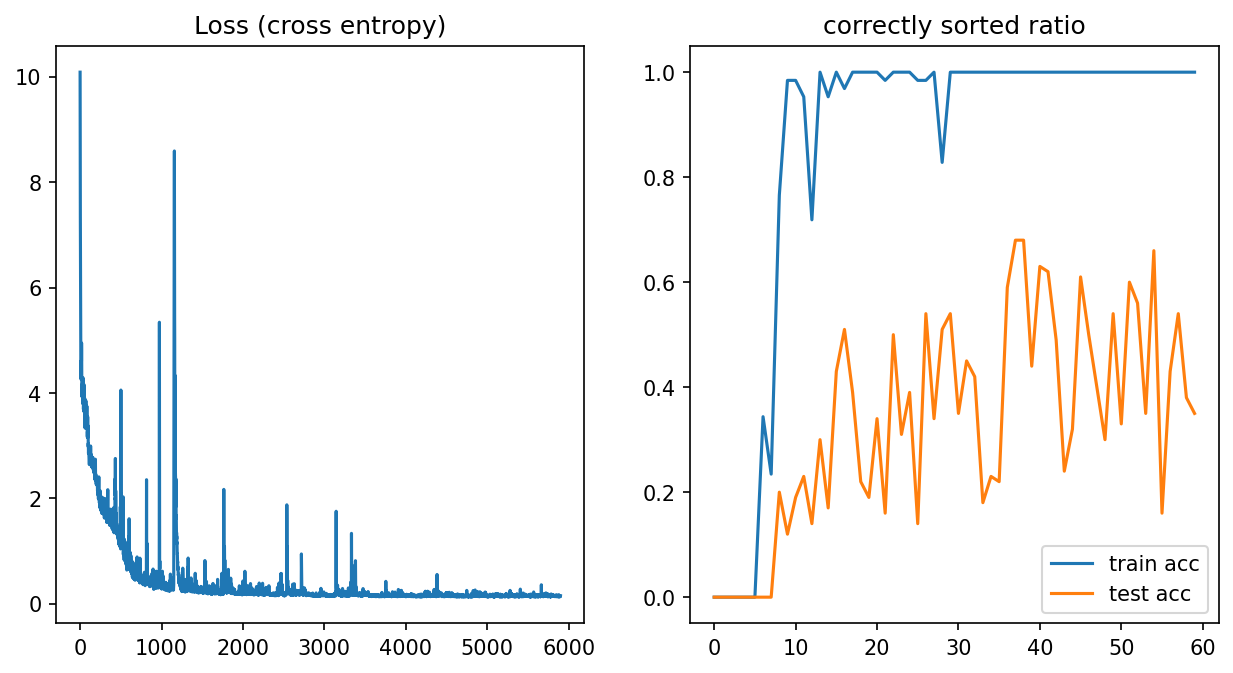

100%|██████████| 6000/6000 [11:47<00:00,  8.48it/s]


In [41]:

if 'start_iteration' not in locals():
    start_iteration = 0
else:
    start_iteration = step

for step in tqdm(range(start_iteration,num_training_iterations)):
    loss = train_step()
    losses.append(loss)
    if step % 100 == 0:
        clear_output()
        pplot.figure(figsize = (10,5), dpi = 150)
        test_acc, train_acc = accuracy_correct_sort()
        accuracy_test.append( test_acc)
        accuracy_train.append(train_acc)
        pplot.subplot(1,2,1)
        pplot.plot(losses)
        pplot.title("Loss (cross entropy)")
        pplot.subplot(1,2,2)
        pplot.plot(accuracy_train, label = "train acc")
        pplot.grid()
        pplot.plot(accuracy_test, label = "test acc")
        pplot.grid()

        pplot.legend()
        pplot.title("correctly sorted ratio")
        pplot.pause(0.1)
        pplot.show()


# Note
In earlier versions of this notebook there was a comparisson with DeepMind GraphNets showing comparable performance.

DeepMind does not seem to maintain the repo anymore, so there is no comparisson.